# Final Project
### Fred Buckhold

## Overview:

This project takes a rough list of current and graduate residents from the Internal Medicine Residency Program at Saint Louis University and will merge this dataset with the National Provider Information database and certificaiton status with the American Board of Internal Medicine.

The goal of this project is develop a framework of getting rather up-to-date information of graduate resident practice location and information and their area of specialty and certification. Ultimately, this dataset can be used against clinical practice data to get a perspective on clinical performance. It could also be used to make comparisons to other residency training programs.  

(Author's note: the imputed dataset has some flaws and needs to be rectified. This coding project is meant to be more proof of concept)

### First, we will get the csv file of a list of residents and modify the data for further analysis:

In [269]:
import requests
import pandas as pd
import json
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt


res_list = pd.read_csv('IM Res Alumni List - Data.csv')
res_list.columns = ['last_name', 'first_name', 'grad_date', 'us_grad', 'do',
       'slusom_grad', 'chief', 'fellow_type', 'fellow_location',
       'fellow_grad_date', 'working_as', 'practice_loc', 'acad',
       'stl', 'ssm', 'slu', 'notes', 'email',
       'contact_info']

del res_list['notes']
del res_list['contact_info']
res_list.shape


(580, 17)

### Column data types and explanation:

'last_name', = last name of resident, string  
'first_name' = first name of resident, string  
'grad_date' = year of residency graduation (string, float, or int)  
'us_grad' = graduate of US-based school, MD/DO, boolean  
'do' = graduate of DO school, boolean  
'slusom_grad?' = graduate of SLUSOM, boolean  
'chief' = did a chief year in program, boolean  
'fellow_type' = specialty of fellow, str  
'fellow_location' = location of fellowship (usually a school), str  
'fellow_grad_date' = year of graduation from fellowship, (string, float, or int)  
'working_as' = type of practice (specialty or general), str  
'practice_loc' = location of practicing, if practicing, str  
'acad' = part of an academic practice, boolean  
'stl' = working in STL region (consider St. Louis, STL County, St. Charles, Jefferson), boolean  
'ssm' = working at an SSM system practice or hospital, boolean  
'slu' = working for SLU practice, boolean  
'email' = email address, if known; str  




In [639]:
res_list['last_name'] = res_list['last_name'].astype(str)
res_list['first_name'] = res_list['first_name'].astype(str)
res_list['fellow_type'] = res_list['fellow_type'].astype(str)
res_list['fellow_location'] = res_list['fellow_location'].astype(str)
res_list['working_as'] = res_list['working_as'].astype(str)
res_list['practice_loc'] = res_list['practice_loc'].astype(str)
res_list['email'] = res_list['email'].astype(str)

res_list['us_grad'] = res_list.us_grad.map({'Yes':True, 'No':False, 'NaN':False})
res_list['do'] = res_list.do.map({'Yes':True, 'No':False, 'NaN':False})
res_list['slusom_grad'] = res_list.slusom_grad.map({'Yes':True, 'No':False, 'NaN':False})
res_list['chief'] = res_list.chief.map({'Yes':True, 'No':False, 'NaN':False})
res_list['acad'] = res_list.acad.map({'Yes':True, 'No':False, 'NaN':False})
res_list['stl'] = res_list.stl.map({'Yes':True, 'No':False, 'NaN':False})
res_list['ssm'] = res_list.ssm.map({'Yes':True, 'No':False, 'NaN':False})
res_list['slu'] = res_list.slu.map({'Yes':True, 'No':False, 'NaN':False})

res_list['grad_date'] = res_list['grad_date'].astype(str)
res_list['fellow_grad_date'] = res_list['fellow_grad_date'].astype(str)


In [108]:
res_list.head()

,last_name,first_name,grad_date,us_grad,do,slusom_grad,chief,fellow_type,fellow_location,fellow_grad_date,working_as,practice_loc,acad,stl,ssm,slu,email
0,Cseri,Zoltan,2002,True,False,False,False,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,nan
1,Dalcanto,Albert,2002,True,False,False,False,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,nan
2,Duong,Vu,2002,True,False,True,False,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,nan
3,Hennemeyer,Charles,2002,True,False,True,False,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,nan
4,Jones,Ramoun,2002,True,False,False,False,nan,nan,nan,nan,nan,NaN,NaN,NaN,NaN,nan


The program has on average 26 residents per year. Let's see how the data looks per year: 

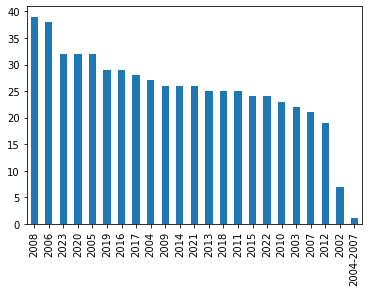

In [312]:
res_list['grad_date'].value_counts().plot.bar()

## Getting data from NPI API
### (data downloads as a JSON that needs parsing)

This is the first large function to get data based on a resident name from the NPI.
As some resident graduates will have a common name, there is code to identify those that practice "Internal Medicine". If there is more than on Internal Medicine provider, the function returns "needs attention" so a filter may be applied and the proper person may be identifed. 

Further code, after running the function, is to clean up the dataset and do some analysis

In [105]:
def get_names_npi1(first, last):
    url = 'https://npiregistry.cms.hhs.gov/api/?number=&enumeration_type=&taxonomy_description=&first_name={}&use_first_name_alias=&last_name={}&organization_name=&address_purpose=&city=&state=&postal_code=&country_code=&limit=50&skip=&version=2.1'.format(first, last)
    resp = requests.get(url)
    data = resp.json() 
    count = data.get('result_count')
    result = data.get('results')
    output =[]
    npi = ()
    first_name = ()
    last_name = ()
    degree = ()
    gender = ()
    city = ()
    state = ()
    zipcode = ()
    state_lic = ()
    lic_no = ()
    specialty = ()         
    if len(result) > 0:
        if count == 1: 
            npi = result[0].get('number') 
            first_name = result[0].get('basic').get('first_name')
            last_name = result[0].get('basic').get('last_name')
            degree = result[0].get('basic').get('credential')
            gender = result[0].get('basic').get('gender')
            city = result[0].get('addresses')[0].get('city')
            state = result[0].get('addresses')[0].get('state')
            zipcode = result[0].get('addresses')[0].get('postal_code')
            state_lic = result[0].get('taxonomies')[0].get('state')
            lic_no = result[0].get('taxonomies')[0].get('license')
            specialty = result[0].get('taxonomies')[0].get('desc') 
        elif count > 1:
            for i in result:
                if i.get('taxonomies')[0].get('desc') == 'Internal Medicine':
                    output.append(i.get('number'))
                else: 
                    pass
    else: 
        npi = -1
        first_name = -1
        last_name = - 1
        degree = -1
        gender = -1
        city = -1
        state = -1
        zipcode = -1
        state_lic = -1
        lic_no = -1
        specialty = -1
        
    if len(output) == 1:
        number = output[0]
        url2 = 'https://npiregistry.cms.hhs.gov/api/?number={}&enumeration_type=&taxonomy_description=&first_name=&use_first_name_alias=&last_name=&organization_name=&address_purpose=&city=&state=&postal_code=&country_code=&limit=50&skip=&version=2.1'.format(number)
        resp2 = requests.get(url2)
        data2 = resp2.json()
        result2 = data2.get('results')

        npi = result2[0].get('number') 
        first_name = result2[0].get('basic').get('first_name')
        last_name = result2[0].get('basic').get('last_name')
        degree = result2[0].get('basic').get('credential')
        gender = result2[0].get('basic').get('gender')
        city = result2[0].get('addresses')[0].get('city')
        state = result2[0].get('addresses')[0].get('state')
        zipcode = result2[0].get('addresses')[0].get('postal_code')
        state_lic = result2[0].get('taxonomies')[0].get('state')
        lic_no = result2[0].get('taxonomies')[0].get('license')
        specialty = result2[0].get('taxonomies')[0].get('desc') 
    elif len(output) > 1:
        npi = 'needs review'
        first_name = 'needs review'
        last_name = 'needs review'
        degree = 'needs review'
        gender = 'needs review'
        city = 'needs review'
        state = 'needs review'
        zipcode = 'needs review'
        state_lic = 'needs review'
        lic_no = 'needs review'
        specialty = 'needs review'
    
    return pd.Series([npi, first_name, last_name, degree, gender, city, state, zipcode, state_lic, lic_no, specialty])

In [109]:
result = res_list.head(497).apply(lambda x: get_names_npi1(x['first_name'], x['last_name']), axis=1)

In [440]:
result.columns = ['npi', 'first_name1', 'last_name1', 'degree', 'gender', 'city', 'state', 'zipcode', 'state_lic', 'lic_no', 'specialty']

### How many residents are in each state?

In [378]:
state = result['state'].value_counts().reset_index()
state = state.drop([1, 2, 3])

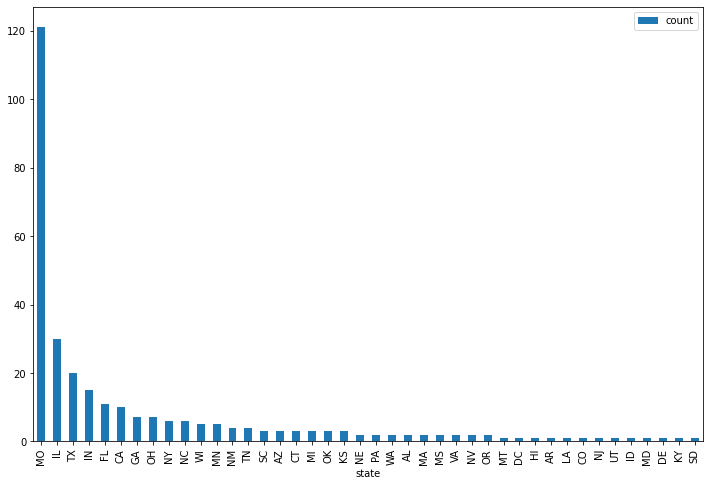

In [391]:
state.columns = ['state', 'count']
state.plot.bar(figsize = (12,8),
               x = 'state',
              y = 'count')

### What cities are residents located in?

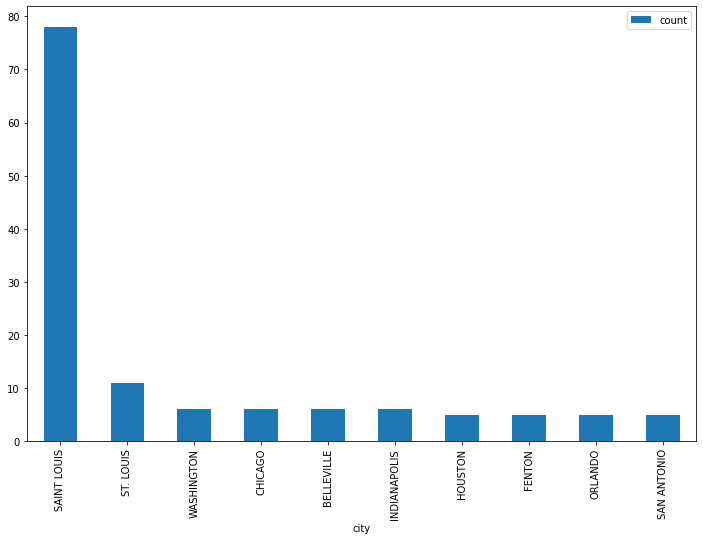

In [418]:
#sort by city
city = result['city'].value_counts().reset_index()
city = city.drop([0, 2, 3])
city.columns = ['city', 'count']
city1 = city[city['count'] > 4]
city1.plot.bar(figsize = (12, 8),
              x = 'city',
              y = 'count')

### Combined list and analysis
The following combines the original list with the npi data gathered. A pivot table is then run to identify types of students (US grads, Grads from DO schools, and SLU grads). A second analysis is done for gender, by graduating year

In [448]:
combined_res = pd.concat([res_list, result], axis=1)

In [449]:
combined_res = combined_res.drop(['first_name1', 'last_name1'], axis=1)

In [484]:
combined_res.columns

Index(['last_name', 'first_name', 'grad_date', 'us_grad', 'do', 'slusom_grad',
       'chief', 'fellow_type', 'fellow_location', 'fellow_grad_date',
       'working_as', 'practice_loc', 'acad', 'stl', 'ssm', 'slu', 'email',
       'npi', 'degree', 'gender', 'city', 'state', 'zipcode', 'state_lic',
       'lic_no', 'specialty'],
      dtype='object')

In [520]:
resident_breakdown = combined_res.pivot_table(index ='grad_date', columns = ['us_grad', 'do', 'slusom_grad'], values = 'npi', aggfunc='count')

resident_breakdown.columns = ['not_us', 'do_error', 'us_not_slu', 'do', 'slu', 'error']

resident_breakdown

,not_us,do_error,us_not_slu,do,slu,error
grad_date,,,,,,
2002,NaN,NaN,3.0,3.0,1.0,NaN
2003,10.0,NaN,2.0,7.0,3.0,NaN
2004,7.0,NaN,13.0,2.0,2.0,NaN
2005,11.0,NaN,10.0,7.0,1.0,NaN
2006,12.0,1.0,8.0,5.0,5.0,NaN
2007,17.0,NaN,NaN,2.0,2.0,NaN
2008,18.0,NaN,8.0,9.0,2.0,NaN
2009,14.0,NaN,4.0,4.0,3.0,NaN
2010,14.0,NaN,5.0,4.0,NaN,NaN


In [579]:
gender = pd.melt(combined_res, id_vars = ['grad_date'], value_vars= ['gender'])
gender.head()

,grad_date,variable,value
0,2002,gender,M
1,2002,gender,-1
2,2002,gender,()
3,2002,gender,M
4,2002,gender,M


In [583]:
filter = ((gender['value'] == 'M') | (gender['value'] == 'F'))

In [591]:
g = gender[filter].reset_index()


/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [592]:
g

,index,grad_date,variable,value
0,0,2002,gender,M
1,3,2002,gender,M
2,4,2002,gender,M
3,5,2002,gender,M
4,6,2002,gender,F
...,...,...,...,...
295,492,2020,gender,F
296,493,2020,gender,F
297,494,2020,gender,M
298,495,2020,gender,M


In [630]:
gend_break = pd.pivot_table(g, index = 'grad_date', columns = 'value', values = 'variable', aggfunc = 'count')

In [631]:
gend_break

value,F,M
grad_date,,
2002,1,4
2003,4,3
2004,3,11
2005,8,13
2006,10,11
2007,4,13
2008,5,16
2009,6,9
2010,5,7


In [632]:
gend_break['F'] = gend_break['F'].astype(int)
gend_break['M'] = gend_break['M'].astype(int)
gend_break = gend_break.reset_index()
gend_break

value,grad_date,F,M
0,2002,1,4
1,2003,4,3
2,2004,3,11
3,2005,8,13
4,2006,10,11
5,2007,4,13
6,2008,5,16
7,2009,6,9
8,2010,5,7
9,2011,8,12


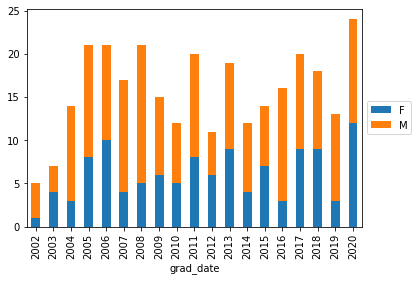

In [638]:
gend_break.set_index('grad_date').plot.bar(stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

### Getting ABIM data
This function pulls html data for certification status for graduates, using the npi number culled from the registry. As a number of entries in the original .csv set did not cull npi results (likely due to errors in the resident list), those entries will need to be removed. Subsequently, a pivot table breaks down residents by specialty. 

In [343]:
def ABIM(npi):
    from bs4 import BeautifulSoup
    url = 'https://www.abim.org/verify-physician?type=npi&npi={}'.format(npi)
    r = requests.get(url)
    soup = BeautifulSoup(r.text)
    boards = []
    if npi == -1:
            return "NA"
    
    else: 
        for element in soup.find_all('div', 'abim_voc-profile'):
                for cert in element.find_all('li'):
                    boards.append(cert.text)
    return pd.Series([npi, boards])

In [344]:
board_status = result.apply(lambda x: ABIM(x['npi']), axis =1)

In [350]:
board_status.columns = ['npi', 'cert1']

In [124]:
board_status = board_status.explode('cert1')

In [127]:
status1 = board_status['cert1'].str.split(": ", expand=True).rename({0: 'cert', 1: 'year_or_status'}, axis=1)

In [129]:
status = pd.concat([board_status, status1], axis=1)

In [183]:
status.shape

(1274, 3)

In [131]:
del status['cert1']

In [164]:
filter = (status['npi'] != 'NA')

In [165]:
status1 = status[filter]

In [182]:
status1.shape

(1163, 3)

In [168]:
filter = status1['npi'] != 'needs review'

In [169]:
status2 = status1[filter]

In [194]:
filter = status2['npi'] != '()'

In [195]:
final = status2[filter]

In [218]:
final = final.reset_index()

In [221]:
final = final.drop([1], axis = 0)

In [222]:
final = final.drop(['index'], axis =1)

In [227]:
final_table = final.pivot_table(index='npi', columns='cert', values='year_or_status', aggfunc='first')

In [504]:
final_table.head()

cert,Advanced Heart Failure and Transplant Cardiology,Cardiovascular Disease,Clinical Cardiac Electrophysiology,Critical Care Medicine,"Endocrinology, Diabetes and Metabolism",Gastroenterology,Geriatric Medicine,Hematology,Hospice and Palliative Medicine,Infectious Disease,...,Internal Medicine with Focused Practice in Hospital Medicine,Interventional Cardiology,Medical Oncology,Nephrology,Participating in Maintenance of Certification,Pulmonary Disease,Rheumatology,Sleep Medicine,Sports Medicine,Transplant Hepatology
npi,,,,,,,,,,,,,,,,,,,,,
1003011578,NaN,NaN,NaN,NaN,NaN,Certified,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN
1003019647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Certified,Yes,NaN,NaN,NaN,NaN,NaN
1003064635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Certified,Yes,NaN,NaN,NaN,NaN,NaN
1003120692,Certified,Certified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN
1003158221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN


In [265]:
specialty = final_table.drop(['Internal Medicine', 'Participating in Maintenance of Certification'], axis =1)

In [266]:
sort_cert = specialty.stack().reset_index()

In [277]:
spec_sort = sort_cert['cert'].value_counts()

In [279]:
spec_sort = spec_sort.reset_index()

In [283]:
spec_sort.columns = ['specialty', 'count']

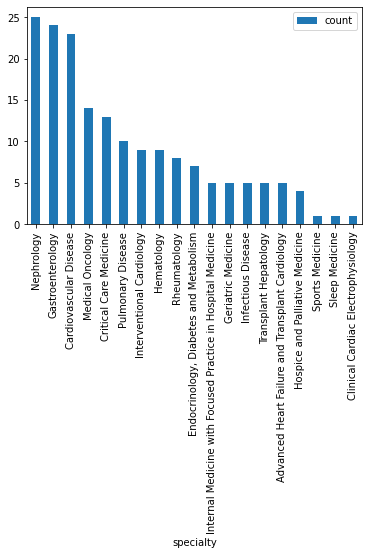

In [300]:
## Graph count by specialty
spec_sort.plot.bar(x = 'specialty', y = 'count')

In [640]:
%%bash
git pull
git add final.ipynb
git commit -a -m "final submitted!"
git push

Already up to date.
[main a4f580a] final submitted!
 3 files changed, 293 insertions(+), 8 deletions(-)


fatal: pathspec 'final.ipynb' did not match any files
To github.com:fbuckhold3/hds5210-2021.git
   20f87ee..a4f580a  main -> main
